In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

import matplotlib.pyplot as plt
import numpy as np

In [57]:
batch_size = 64

In [58]:
device = torch.device("cuda")

In [59]:
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
dataset = datasets.MNIST('data', train=True, download=True, transform=transform)

loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

In [60]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(784, 10)

    def forward(self, x):
        x = self.fc1(x)
        output = F.log_softmax(x, dim=1)
        return output
    
    def get_flatten_params(self):
        flatten_params = torch.tensor([], device=device)

        for p in model.parameters():
            flatten_params = torch.cat((flatten_params, torch.flatten(p)))

        return flatten_params
    
    def _get_param_shapes(self):
        param_shapes = []
        for p in self.parameters():
            param_shapes.append(p.size())
        return param_shapes
    
    def init_from_flatten_params(self, flatten_params):
        param_shapes = self._get_param_shapes()
        param_sizes = [torch.prod(torch.tensor(shape)).item() for shape in param_shapes]
        split_params = torch.split(flatten_params, param_sizes)

        for p, split_param in zip(model.parameters(), split_params):
            p.data.copy_(split_param.view(p.size()))


model = MLP()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.01)

In [61]:
for epoch in range(5):
    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device)

        Xb = data.view(-1, 784)
        
        optimizer.zero_grad()
        output = model(Xb)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

    print(loss.item())

0.17292475700378418
0.13870519399642944
0.12243898957967758
0.11234267055988312
0.10534582287073135


In [67]:
correct = 0

with torch.no_grad():
    for data, target in loader:
        data, target = data.to(device), target.to(device)
        Xb = data.view(-1, 784)

        output = model(Xb)

        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

100. * correct / len(loader.dataset)

91.71666666666667

In [63]:
#bs64 model : 91.7166 train acc
flat_params_bs64 = model.get_flatten_params()

In [66]:
model = MLP()
model.to(device)
model.init_from_flatten_params(flat_params_bs64)

In [49]:
flat_params_bs512 = torch.tensor([], device=device)

for p in model.parameters():
    flat_params_bs512 = torch.cat((flat_params_bs512, torch.flatten(p)))

In [43]:
# interpolate : alpha * theta_0 + (1-alpha) * theta_1

In [71]:
alphas = torch.linspace(start=0, end=1, steps=10)
losses = []

model = MLP()
model.to(device)

for alpha in alphas:
    print("alpha = {}".format(alpha))
    #calculer le cout pour alpha * theta_0 + (1-alpha) * theta_1

    model.init_from_flatten_params(alpha * flat_params_bs64 + (1 - alpha) * flat_params_bs512)
    loss = 0
    compteur = 0

    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            Xb = data.view(-1, 784)

            output = model(Xb)
            loss += F.nll_loss(output, target).item()
            compteur += 1

    loss = loss / compteur #todo : len(loader) ?
    losses.append(loss)

alpha = 0.0
alpha = 0.1111111119389534
alpha = 0.2222222238779068
alpha = 0.3333333432674408
alpha = 0.4444444477558136
alpha = 0.5555555820465088
alpha = 0.6666666865348816
alpha = 0.7777777910232544
alpha = 0.8888888955116272
alpha = 1.0


In [75]:
losses

[0.3756749568455445,
 0.35788753579881016,
 0.3428505510290358,
 0.33018824579650913,
 0.31958440669389293,
 0.31077246901704303,
 0.30352724612410514,
 0.29765805733928297,
 0.29300297151154864,
 0.2894240034354934]

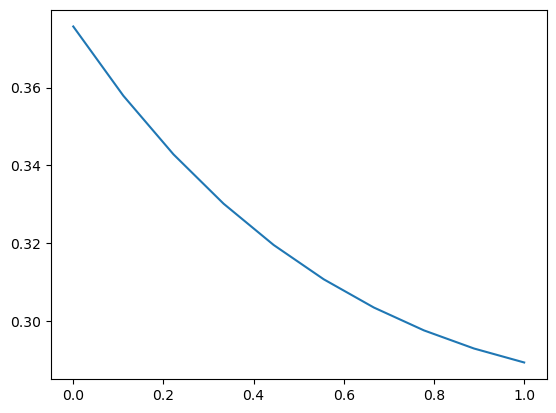

In [78]:
plt.plot(alphas, losses)